## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential, layers, models
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import confusion_matrix
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import cv2
import glob
import os

## **Import Dataset Labels**

In [6]:
# Import labels
train_labels = pd.read_csv("trainLabels.csv")
print(f"The shape of the Labels is: {train_labels.shape}")
print(f"The dataset has {len(train_labels.label.unique())} classes")
train_labels.head()

The shape of the Labels is: (50000, 2)
The dataset has 10 classes


,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


#### Our dataset has 50,000 train images, and there labels are stored in the previous csv file with the image name is stored in the Id column

## **Explore dataset**

In [7]:
def load_image_from_folder(image_name, folder="train"):
    """return a numpy array of an image"""
    image_name += ".png"
    img = cv2.imread(os.path.join(folder, image_name))
    return img

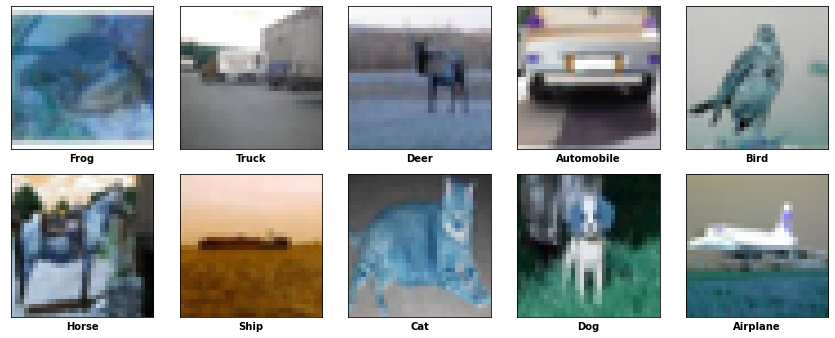

In [8]:
#Visualize random images from every class
fig, ax = plt.subplots(2, 5, figsize=(12, 5))
classes = train_labels.label.unique()
row, col = 0, 0

for i in range(10):
    class_name = classes[i]
    image_name = str(int(train_labels[train_labels.label == class_name].sample().id))
    image = load_image_from_folder(image_name)
    ax[row, col].imshow(image)
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_xlabel(class_name.capitalize(), fontweight='bold')
    fig.tight_layout(pad=2)
    col += 1
    if col == 5:
        col = 0
        row += 1


In [9]:
# The shape of images
image.shape

(32, 32, 3)

#### All images have the same height and width but just to be sure we will set all of them to 32x32

## **Import image dataset**

In [10]:
batch_size = 50
img_height = 32
img_width = 32
input_shape = (img_width, img_height, 3)
labels_array = np.array(pd.get_dummies(train_labels.label))
labels_array.shape

(50000, 10)

In [11]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3)

In [12]:
y_train=tf.keras.utils.to_categorical(y_train)
y_valid=tf.keras.utils.to_categorical(y_valid)
y_test=tf.keras.utils.to_categorical(y_test)


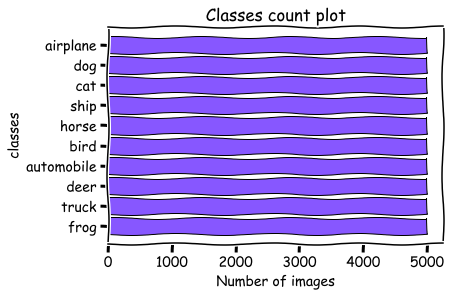

In [13]:
# Count plot for evey class
with plt.xkcd():
    # This figure will be in XKCD-style
    plt.barh(train_labels.label.value_counts().index, train_labels.label.value_counts(),
            color='#8757ff',
            edgecolor='black')
    plt.xlabel("Number of images")
    plt.ylabel("classes")
    plt.title("Classes count plot")

#### As we can see our dataset is balanced and all classes have the same number of images, so that our model will not be skewed to any specific class

## **Transfer Learning with Data Augmentation**

In [64]:
from tensorflow.keras.applications import VGG19

In [65]:
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

In [66]:
model1_transfer = Sequential()
model1_transfer.add(base_model_1)
model1_transfer.add(layers.Flatten())  #Since the output before the flatten layer is a matrix we have to use this function to get
                                #a vectore of the form nx1 to feed it into the fully connected layer

In [67]:
model1_transfer.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [68]:
#Add the Dense layers along with activation and batch normalization
activation = layers.ReLU()

# model1_transfer.add(layers.Dense(1024,activation=activation,input_dim=512))
# model1_transfer.add(layers.BatchNormalization())
# model1_transfer.add(layers.Dense(512,activation=activation))
# model1_transfer.add(layers.BatchNormalization())
model1_transfer.add(layers.Dense(256,activation=activation, input_dim = 512))
model1_transfer.add(layers.BatchNormalization())
model1_transfer.add(layers.Dense(128,activation=activation))
model1_transfer.add(layers.BatchNormalization())
model1_transfer.add(layers.Dense(10,activation=('softmax'))) #This is the classification layer

In [69]:
model1_transfer.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_13 (Batc (None, 128)               512       
_________________________________________________________________
dense_33 (Dense)             (None, 10)               

In [70]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 

In [71]:
train_generator.fit(x_train)
val_generator.fit(x_valid)
test_generator.fit(x_test)

In [72]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model1_transfer.compile(optimizer=optimizer, loss="categorical_crossentropy",
              metrics=["accuracy"])
lrr= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=8, min_lr=1e-2)

early_stop = tf.keras.callbacks.EarlyStopping(restore_best_weights=True,
                                              mode="max", patience=10, 
                                              monitor="val_accuracy")

model1_transfer.fit(train_generator.flow(x_train,y_train,batch_size=batch_size), epochs=100, steps_per_epoch=x_train.shape[0]//100, 
                    validation_data=val_generator.flow(x_valid,y_valid,batch_size=batch_size),
                    validation_steps=250, callbacks=[lrr, early_stop])

Epoch 1/100
350/350 [==============================] - 49s 138ms/step - loss: 1.5073 - accuracy: 0.4622 - val_loss: 2.9284 - val_accuracy: 0.2006
Epoch 2/100
350/350 [==============================] - 54s 153ms/step - loss: 0.8964 - accuracy: 0.6945 - val_loss: 1.1782 - val_accuracy: 0.6518
Epoch 3/100
350/350 [==============================] - 73s 210ms/step - loss: 0.7626 - accuracy: 0.7438 - val_loss: 0.7838 - val_accuracy: 0.7316
Epoch 4/100
350/350 [==============================] - 54s 156ms/step - loss: 0.6696 - accuracy: 0.7686 - val_loss: 0.6697 - val_accuracy: 0.7686
Epoch 5/100
350/350 [==============================] - 76s 218ms/step - loss: 0.6233 - accuracy: 0.7898 - val_loss: 0.7306 - val_accuracy: 0.7488
Epoch 6/100
350/350 [==============================] - 51s 147ms/step - loss: 0.5706 - accuracy: 0.8065 - val_loss: 0.8122 - val_accuracy: 0.7347
Epoch 7/100
350/350 [==============================] - 65s 187ms/step - loss: 0.5154 - accuracy: 0.8251 - val_loss: 0.7258 -

In [73]:
# Save the model
history = model1_transfer.history
model1_transfer.save("CNN_model.model")

INFO:tensorflow:Assets written to: CNN_model.model\assets


INFO:tensorflow:Assets written to: CNN_model.model\assets


## **Building CNN architectures**

In [65]:
#Create a model
model = Sequential()

#Create an activation function
activation = layers.ELU()

# add more layers
model.add(layers.Conv2D(16, kernel_size=3, padding="same", input_shape=(img_width, img_height, 3)))
model.add(activation)

model.add(layers.Conv2D(32, kernel_size=3, padding="same"))
model.add(activation)
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
model.add(activation)
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(128, kernel_size=3,padding="same"))
model.add(activation)
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(256, kernel_size=3, padding="same"))
model.add(activation)

model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation=activation))
model.add(layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
elu_1 (ELU)                  multiple                  0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)         

In [66]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss="categorical_crossentropy",
              metrics=["accuracy"])
lrr= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=.001, patience=8, min_lr=1e-5)

early_stop = tf.keras.callbacks.EarlyStopping(restore_best_weights=True,
                                              mode="max", patience=6, 
                                              monitor="val_accuracy")

model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), shuffle=True, callbacks=[lrr, early_stop])

Epoch 1/100
1094/1094 [==============================] - 13s 11ms/step - loss: 1.5787 - accuracy: 0.4890 - val_loss: 1.1513 - val_accuracy: 0.5902
Epoch 2/100
1094/1094 [==============================] - 12s 11ms/step - loss: 1.0393 - accuracy: 0.6347 - val_loss: 1.0029 - val_accuracy: 0.6471
Epoch 3/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.8901 - accuracy: 0.6910 - val_loss: 0.9983 - val_accuracy: 0.6367
Epoch 4/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.8238 - accuracy: 0.7155 - val_loss: 0.7979 - val_accuracy: 0.7169
Epoch 5/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.7530 - accuracy: 0.7379 - val_loss: 0.8672 - val_accuracy: 0.7046
Epoch 6/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.7112 - accuracy: 0.7543 - val_loss: 0.8713 - val_accuracy: 0.7044
Epoch 7/100
1094/1094 [==============================] - 12s 11ms/step - loss: 0.6809 - accuracy: 0.7669 - val_loss: 0

In [55]:
%%bash
export TF_CONFIG='{"device_type": "GPU:0"}'

#### We will choose the transfer leanring model

## **Model Evaluation**

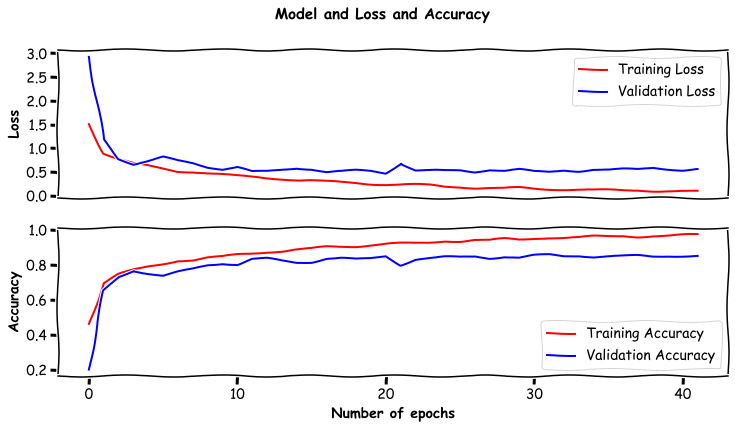

In [74]:
with plt.xkcd():
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))

    ax[0].plot(history.history["loss"], label="Training Loss", color="r")
    ax[0].plot(history.history["val_loss"], label="Validation Loss", color="b")
    ax[0].set_xticks([])
    ax[0].set_ylabel("Loss", fontweight="bold")
    ax[0].legend()

    ax[1].plot(history.history["accuracy"], label="Training Accuracy", color="r")
    ax[1].plot(history.history["val_accuracy"], color="b", label="Validation Accuracy")
    ax[1].legend(loc="lower right")
    ax[1].set_xlabel("Number of epochs", fontweight="bold")
    ax[1].set_ylabel("Accuracy", fontweight="bold")

    fig.suptitle("Model and Loss and Accuracy", fontsize=15, fontweight="bold");

In [75]:
# Train data Predictions
train_predictions = model1_transfer.predict(x_train)
train_predictions_list = list(train_predictions.argmax(axis=-1))

In [76]:
# True labels
train_true_labels = list(y_train.argmax(axis=-1))
validation_true_labels = list(y_valid.argmax(axis=-1))

In [77]:
# Validation data predictions
valid_predictions = model1_transfer.predict(x_valid)
valid_predictions_list = list(valid_predictions.argmax(axis=-1))

In [78]:
# Accuracy
train_accuracy = accuracy_score(train_true_labels, train_predictions_list)
validation_accuracy = accuracy_score(validation_true_labels, valid_predictions_list)

print(f"Accuracy on Train Data is: {train_accuracy}")
print(f"Accuracy on Validation Data is: {validation_accuracy}")

Accuracy on Train Data is: 0.9614857142857143
Accuracy on Validation Data is: 0.8574666666666667


In [79]:
# Confusion matrix
cm_train = confusion_matrix(train_true_labels, train_predictions_list)
cm_valid = confusion_matrix(validation_true_labels, valid_predictions_list)

In [80]:
labels_dict = {0 : "Airplane", 
               1 : "Automobile",
               2 : "Bird",
               3 : "Cat",
               4 : "Deer",
               5 : "Dog",
               6 : "Frog",
               7 : "Horse",
               8 : "Ship",
               9 : "Truck"}

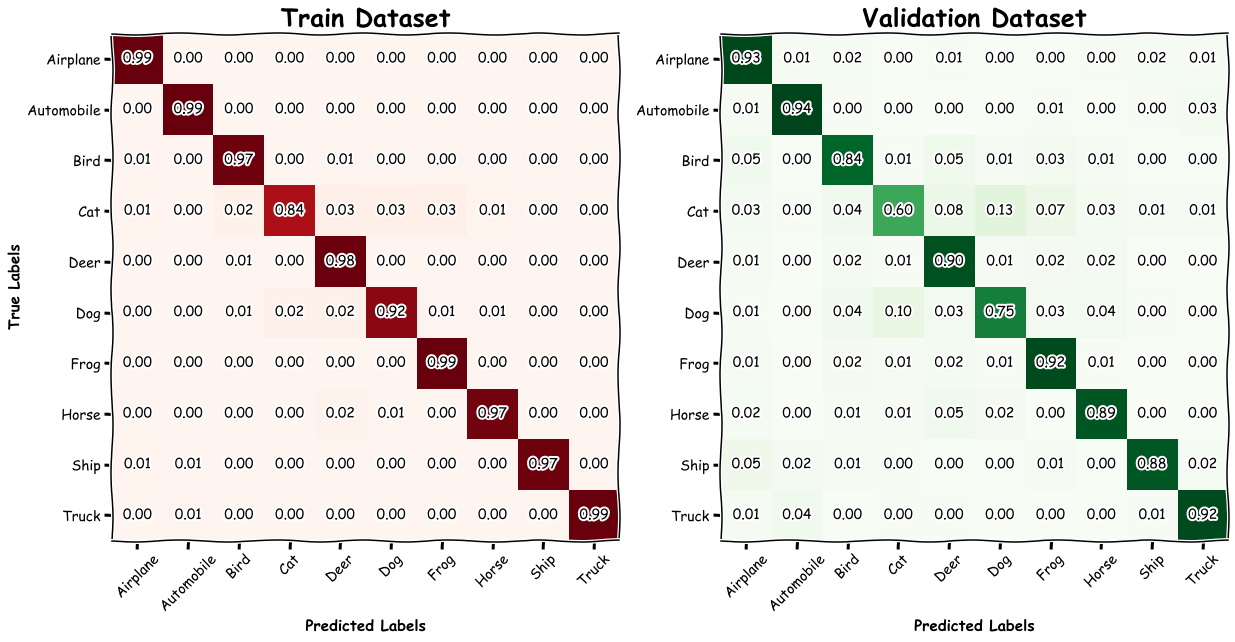

In [81]:
with plt.xkcd():
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    plot_confusion_matrix(conf_mat=cm_train, axis=ax[0], cmap="Reds",
                         show_normed=True, show_absolute=False,
                         fontcolor_threshold=50)
    ax[0].set_xticks([i for i in range(10)])
    ax[0].set_yticks([i for i in range(10)])
    ax[0].set_xticklabels(labels_dict.values(), rotation=45)
    ax[0].set_yticklabels(labels_dict.values())
    ax[0].set_xlabel('Predicted Labels', fontsize=15, fontweight="bold")
    ax[0].set_ylabel('True Labels', fontsize=15, fontweight="bold")
    ax[0].set_title("Train Dataset", fontsize=25, fontweight="bold")
    
    plot_confusion_matrix(conf_mat=cm_valid, axis=ax[1],
                         show_normed=True, show_absolute=False,
                         fontcolor_threshold=50, cmap="Greens")
    ax[1].set_xticks([i for i in range(10)])
    ax[1].set_yticks([i for i in range(10)])
    ax[1].set_xticklabels(labels_dict.values(), rotation=45)
    ax[1].set_yticklabels(labels_dict.values())
    ax[1].set_xlabel('Predicted Labels', fontsize=15, fontweight="bold")
    ax[1].set_ylabel("")
    ax[1].set_title("Validation Dataset", fontsize=25, fontweight="bold")

    
    

In [82]:
# Classification Report
print(classification_report(validation_true_labels, valid_predictions_list, target_names=labels_dict.values()))

              precision    recall  f1-score   support

    Airplane       0.83      0.93      0.87      1517
  Automobile       0.92      0.94      0.93      1544
        Bird       0.82      0.84      0.83      1432
         Cat       0.80      0.60      0.69      1496
        Deer       0.79      0.90      0.84      1497
         Dog       0.81      0.75      0.78      1504
        Frog       0.84      0.92      0.88      1497
       Horse       0.89      0.89      0.89      1493
        Ship       0.95      0.88      0.92      1514
       Truck       0.92      0.92      0.92      1506

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.85     15000
weighted avg       0.86      0.86      0.86     15000



In [88]:
# get predictions on test data
test_predictions = model1_transfer.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=-1)

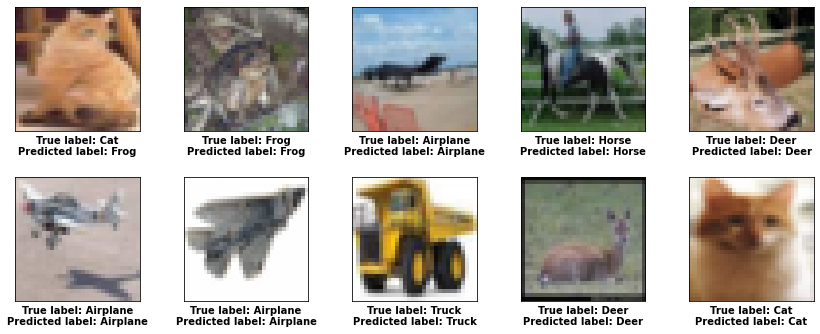

In [119]:
# plot random images from test data nd check their predictions
fig, ax = plt.subplots(2, 5, figsize=(12, 5))
row, col = 0, 0
for i in range(10):
    img_idx = np.random.randint(0, len(y_test))
    x_label = "True label: " + labels_dict[y_test[img_idx][0]]\
            + "\nPredicted label: " + labels_dict[test_predictions[img_idx]]
    image = x_test[img_idx]
    ax[row, col].imshow(image)
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_xlabel(x_label, fontweight='bold')
    fig.tight_layout(pad=2)
    col += 1
    if col == 5:
        col = 0
        row += 1

## **Done**